In [28]:
import numpy as np
import pandas as pd
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest 
from statsmodels.tsa.arima_model import ARIMA
from arch import arch_model
import seaborn as sns
import yfinance
import warnings
warnings.filterwarnings("ignore")
sns.set()
from statsmodels.graphics.tsaplots import plot_pacf

In [18]:
raw_data = yfinance.download (tickers = "VOW3.DE, PAH3.DE, BMW.DE", interval = "1d", group_by = 'ticker',
                              auto_adjust = True, treads = True)

[*********************100%***********************]  3 of 3 completed


In [19]:
df = raw_data.copy()

In [20]:
df.head()

PAH3.DE                           BMW.DE                        \
              Open High Low Close Volume       Open       High        Low   
Date                                                                        
1996-11-08     NaN  NaN NaN   NaN    NaN  10.539517  10.539517  10.516945   
1996-11-11     NaN  NaN NaN   NaN    NaN  10.527945  10.533733  10.465437   
1996-11-12     NaN  NaN NaN   NaN    NaN  10.511159  10.607814  10.471223   
1996-11-13     NaN  NaN NaN   NaN    NaN  10.617074  10.617074  10.527943   
1996-11-14     NaN  NaN NaN   NaN    NaN  10.536624  10.585241  10.494374   

                                 VOW3.DE                        
                Close     Volume    Open High Low Close Volume  
Date                                                            
1996-11-08  10.516945   767000.0     NaN  NaN NaN   NaN    NaN  
1996-11-11  10.488587   260000.0     NaN  NaN NaN   NaN    NaN  
1996-11-12  10.567880  1066000.0     NaN  NaN NaN   NaN    NaN  
1996-11-13  10.551093   793000.0     NaN  NaN NaN   NaN    NaN  
1996-11-14  10.585241   351000.0     NaN  NaN NaN   NaN    NaN

In [21]:
#Key Dates
# Starting Date
start_date = "2009-04-05" 

# First Official Announcement - 49.9%
ann_1 = "2009-12-09" 

# Second Official Announcement - 51.1%
ann_2 = "2012-07-05" 

#Ending Date
end_date = "2014-01-01"

# Dieselgate
d_gate = '2015-09-20' 

In [22]:
# Data Pre-processing
# Extracting Closing Prices
df['vol'] = df['VOW3.DE'].Close
df['por'] = df['PAH3.DE'].Close
df['bmw'] = df['BMW.DE'].Close

# Creating Returns
df['ret_vol'] = df['vol'].pct_change(1).mul(100)
df['ret_por'] = df['por'].pct_change(1).mul(100)
df['ret_bmw'] = df['bmw'].pct_change(1).mul(100)

# Creating Squared Returns
df['sq_vol'] = df.ret_vol.mul(df.ret_vol)
df['sq_por'] = df.ret_por.mul(df.ret_por)
df['sq_bmw'] = df.ret_bmw.mul(df.ret_bmw)

# Extracting Volume
df['q_vol'] = df['VOW3.DE'].Volume
df['q_por'] = df['PAH3.DE'].Volume
df['q_bmw'] = df['BMW.DE'].Volume

In [24]:
return_vol= df['ret_vol'][start_date:end_date]

In [9]:
df['VOW3.DE'][start_date:end_date].Close.head()

Date
2009-04-06    37.437588
2009-04-07    39.262333
2009-04-08    39.503616
2009-04-09    41.901440
2009-04-14    42.451878
Name: Close, dtype: float64

In [10]:
# Assigning the Frequency and Filling NA Values
df = df.asfreq('b')
df = df.fillna(method='bfill')

In [11]:
# Removing Surplus Data
del df['VOW3.DE']
del df['PAH3.DE']
del df['BMW.DE']

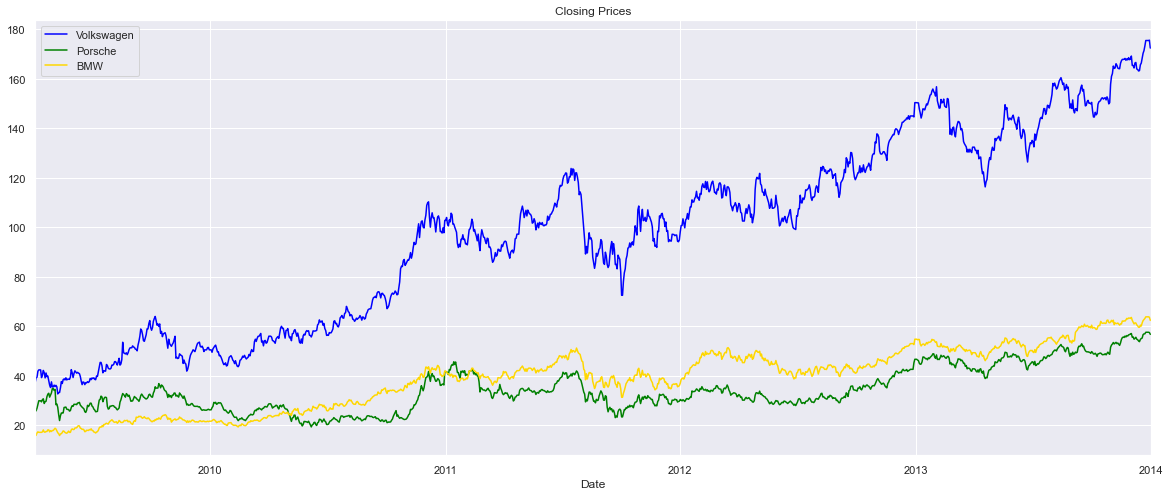

In [12]:
#EDA
df['vol'][start_date:end_date].plot(figsize= (20,8), color = "blue")
df['por'][start_date:end_date].plot(color = "green")
df['bmw'][start_date:end_date].plot(color = "gold")
plt.title("Closing Prices")
plt.legend(['Volkswagen','Porsche','BMW'])
plt.show()

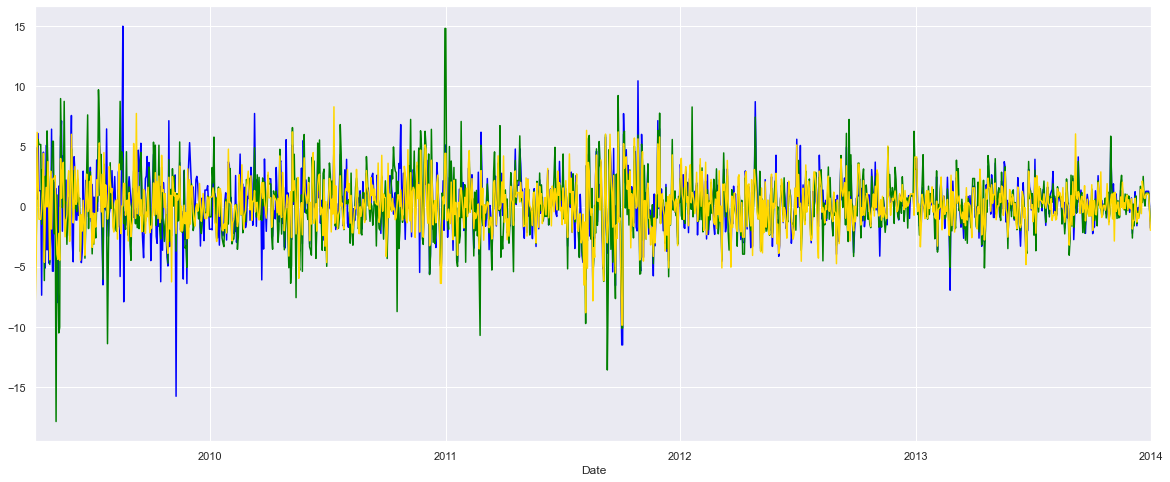

In [73]:
df['ret_vol'][start_date:end_date].plot(figsize= (20,8), color = "blue")
df['ret_por'][start_date:end_date].plot(color = "green")
df['ret_bmw'][start_date:end_date].plot(color = "gold")
plt.show()

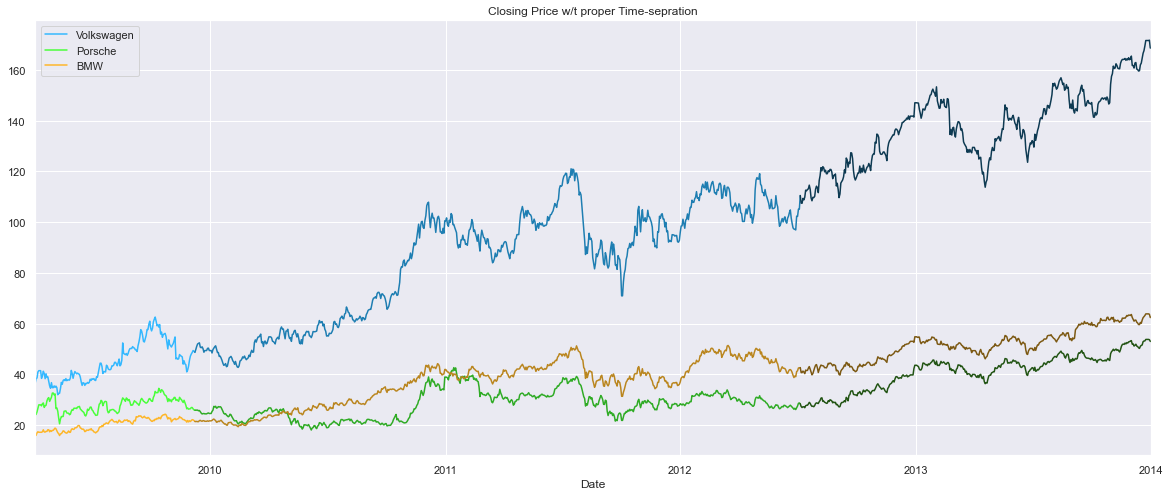

In [74]:
df['vol'][start_date:ann_1].plot(figsize= (20,8), color = "#33B8FF")
df['por'][start_date:ann_1].plot(color = "#49FF3A")
df['bmw'][start_date:ann_1].plot(color = "#FEB628")

df['vol'][ann_1:ann_2].plot(color = "#1E7EB2")
df['por'][ann_1:ann_2].plot(color = "#2FAB25")
df['bmw'][ann_1:ann_2].plot(color = "#BA861F")

df['vol'][ann_2:end_date].plot(color = "#0E3A52")
df['por'][ann_2:end_date].plot(color = "#225414")
df['bmw'][ann_2:end_date].plot(color = "#7C5913")

plt.legend(['Volkswagen','Porsche','BMW'])
plt.title("Closing Price w/t proper Time-sepration")

plt.show()

In [75]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['por'][start_date:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:end_date].corr(df['bmw'][start_date:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:end_date].corr(df['bmw'][start_date:end_date])))

Correlation among manufacturers from 2009-04-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.8348050084649201
Volkswagen and BMW correlation: 	0.9799384525546676
Porsche and BMW correlation: 		0.8039398538655349


In [76]:
print('Correlation among manufacturers from ' + str(start_date) + ' to ' + str(ann_1)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['por'][start_date:ann_1])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][start_date:ann_1].corr(df['bmw'][start_date:ann_1])))

Correlation among manufacturers from 2009-04-05 to 2009-12-09

Volkswagen and Porsche correlation: 	0.6633400945227693
Volkswagen and BMW correlation: 	0.8428353828601808
Porsche and BMW correlation: 		0.6095046037466961


In [77]:
print('Correlation among manufacturers from ' + str(ann_1) + ' to ' + str(ann_2)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['por'][ann_1:ann_2])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_1:ann_2].corr(df['bmw'][ann_1:ann_2])))

Correlation among manufacturers from 2009-12-09 to 2012-07-05

Volkswagen and Porsche correlation: 	0.7422114342529975
Volkswagen and BMW correlation: 	0.9795943008992956
Porsche and BMW correlation: 		0.7035985533162737


In [78]:
print('Correlation among manufacturers from ' + str(ann_2) + ' to ' + str(end_date)+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['por'][ann_2:end_date])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][ann_2:end_date].corr(df['bmw'][ann_2:end_date])))

Correlation among manufacturers from 2012-07-05 to 2014-01-01

Volkswagen and Porsche correlation: 	0.9405237308477348
Volkswagen and BMW correlation: 	0.9284447459439166
Porsche and BMW correlation: 		0.9494111766213098


In [79]:
print('Correlation among manufacturers from ' + str(end_date) + ' to ' + str(df.index[-1])+ '\n')
print('Volkswagen and Porsche correlation: \t'+ str(df['vol'][end_date:].corr(df['por'][end_date:])))
print('Volkswagen and BMW correlation: \t'+ str(df['vol'][end_date:].corr(df['bmw'][end_date:])))
print('Porsche and BMW correlation: \t\t'+ str(df['por'][end_date:].corr(df['bmw'][end_date:])))

Correlation among manufacturers from 2014-01-01 to 2020-12-29 00:00:00

Volkswagen and Porsche correlation: 	0.9389776799345942
Volkswagen and BMW correlation: 	0.5247677103578418
Porsche and BMW correlation: 		0.4759917217260795


In [80]:
# Best Fitting Model
# Volkswagon
mod_pr_pre_vol = auto_arima(df.vol[start_date:ann_1], exogenous = df[['por','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_vol = auto_arima(df.vol[ann_1:ann_2], exogenous = df[['por','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_vol = auto_arima(df.vol[ann_2:end_date], exogenous = df[['por','bmw']][ann_2:end_date],
                            m = 5, max_p = 5, max_q = 5)

In [81]:
mod_pr_pre_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -323.195
Date:                Wed, 30 Dec 2020   AIC                            656.390
Time:                        09:11:35   BIC                            672.299
Sample:                    04-06-2009   HQIC                           662.841
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.7236      0.447      1.618      0.106      -0.153       1.600
por            0.4179      0.100      4.169      0.000       0.221       0.614
bmw            0.6615      0.314      2.108      0.035       0.046       1.277
ar.L1          0.9634      0.020     48.675      0.000       0.925       1.002
sigma2         2.1787      0.148     14.718      0.000       1.889       2.469
===================================================================================
Ljung-Box (L1) (Q):                   0.77   Jarque-Bera (JB):               166.09
Prob(Q):                              0.38   Prob(JB):                         0.00
Heteroskedasticity (H):               1.61   Skew:                            -0.52
Prob(H) (two-sided):                  0.07   Kurtosis:                         7.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [82]:
mod_pr_btn_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1080.895
Date:                Wed, 30 Dec 2020   AIC                           2167.789
Time:                        09:11:35   BIC                           2181.315
Sample:                    12-09-2009   HQIC                          2173.028
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            0.8277      0.064     12.833      0.000       0.701       0.954
bmw            1.4806      0.070     21.267      0.000       1.344       1.617
sigma2         1.4680      0.060     24.528      0.000       1.351       1.585
===================================================================================
Ljung-Box (L1) (Q):                   2.07   Jarque-Bera (JB):               112.32
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               1.65   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
mod_pr_post_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -608.235
Date:                Wed, 30 Dec 2020   AIC                           1222.471
Time:                        09:11:36   BIC                           1234.362
Sample:                    07-05-2012   HQIC                          1227.185
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
por            1.7999      0.059     30.369      0.000       1.684       1.916
bmw            0.8197      0.087      9.381      0.000       0.648       0.991
sigma2         1.3355      0.065     20.461      0.000       1.208       1.463
===================================================================================
Ljung-Box (L1) (Q):                   0.23   Jarque-Bera (JB):               103.80
Prob(Q):                              0.63   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                            -0.39
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.41
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [84]:
#Porshe
mod_pr_pre_por = auto_arima(df.por[start_date:ann_1], exogenous = df[['vol','bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_por = auto_arima(df.por[ann_1:ann_2], exogenous = df[['vol','bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_por = auto_arima(df.por[ann_2:end_date], exogenous = df[['vol','bmw']][ann_2:end_date],
                             m = 5, max_p = 5, max_q = 5)

In [85]:
mod_pr_pre_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -218.214
Date:                Wed, 30 Dec 2020   AIC                            448.427
Time:                        09:12:08   BIC                            467.518
Sample:                    04-06-2009   HQIC                           456.169
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5516      0.360      1.533      0.125      -0.154       1.257
vol            0.1101      0.051      2.157      0.031       0.010       0.210
bmw            0.8068      0.145      5.557      0.000       0.522       1.091
ar.L1          1.0747      0.059     18.194      0.000       0.959       1.191
ar.L2         -0.1589      0.059     -2.716      0.007      -0.274      -0.044
sigma2         0.6721      0.048     14.098      0.000       0.579       0.766
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               559.43
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.21   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
mod_pr_btn_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:               SARIMAX(1, 1, 1)   Log Likelihood                -550.899
Date:                Wed, 30 Dec 2020   AIC                           1111.797
Time:                        09:12:08   BIC                           1134.341
Sample:                    12-09-2009   HQIC                          1120.529
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.1704      0.015     11.128      0.000       0.140       0.200
bmw            0.3030      0.042      7.206      0.000       0.221       0.385
ar.L1          0.6598      0.229      2.883      0.004       0.211       1.108
ma.L1         -0.5910      0.245     -2.412      0.016      -1.071      -0.111
sigma2         0.3024      0.009     32.415      0.000       0.284       0.321
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1076.71
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.39   Skew:                             0.05
Prob(H) (two-sided):                  0.01   Kurtosis:                         9.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [87]:
mod_pr_post_por.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  390
Model:             SARIMAX(0, 1, 0)x(0, 0, [1], 5)   Log Likelihood                -192.826
Date:                             Wed, 30 Dec 2020   AIC                            393.653
Time:                                     09:12:08   BIC                            409.507
Sample:                                 07-05-2012   HQIC                           399.938
                                      - 01-01-2014                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
vol            0.2119      0.013     16.876      0.000       0.187       0.237
bmw            0.2286      0.038      6.036      0.000       0.154       0.303
ma.S.L5       -0.1249      0.057     -2.210      0.027      -0.236      -0.014
sigma2         0.1578      0.006     27.851      0.000       0.147       0.169
===================================================================================
Ljung-Box (L1) (Q):                   2.09   Jarque-Bera (JB):               613.58
Prob(Q):                              0.15   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [88]:
mod_pr_pre_ret_vol = auto_arima(df.ret_vol[start_date:ann_1], exogenous = df[['ret_por','ret_bmw']][start_date:ann_1],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_btn_ret_vol = auto_arima(df.ret_vol[ann_1:ann_2], exogenous = df[['ret_por','ret_bmw']][ann_1:ann_2],
                            m = 5, max_p = 5, max_q = 5)
mod_pr_post_ret_vol = auto_arima(df.ret_vol[ann_2:end_date], exogenous = df[['ret_por','ret_bmw']][ann_2:end_date],
                            m = 5, max_p = 5, max_q = 5)

In [89]:
mod_pr_pre_ret_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  178
Model:                        SARIMAX   Log Likelihood                -464.578
Date:                Wed, 30 Dec 2020   AIC                            935.156
Time:                        09:12:31   BIC                            944.702
Sample:                    04-06-2009   HQIC                           939.027
                         - 12-09-2009                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ret_por        0.2657      0.057      4.625      0.000       0.153       0.378
ret_bmw        0.1920      0.114      1.681      0.093      -0.032       0.416
sigma2        10.8277      0.754     14.366      0.000       9.350      12.305
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):                64.38
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               0.77   Skew:                            -0.29
Prob(H) (two-sided):                  0.32   Kurtosis:                         5.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [90]:
mod_pr_post_ret_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  390
Model:                        SARIMAX   Log Likelihood                -522.637
Date:                Wed, 30 Dec 2020   AIC                           1051.274
Time:                        09:12:32   BIC                           1063.172
Sample:                    07-05-2012   HQIC                          1055.991
                         - 01-01-2014                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ret_por        0.4877      0.019     25.060      0.000       0.450       0.526
ret_bmw        0.3502      0.035      9.970      0.000       0.281       0.419
sigma2         0.8541      0.033     25.753      0.000       0.789       0.919
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):               388.29
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
mod_pr_btn_ret_vol.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  672
Model:                        SARIMAX   Log Likelihood               -1222.937
Date:                Wed, 30 Dec 2020   AIC                           2451.873
Time:                        09:12:32   BIC                           2465.404
Sample:                    12-09-2009   HQIC                          2457.114
                         - 07-05-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ret_por        0.2900      0.025     11.832      0.000       0.242       0.338
ret_bmw        0.5844      0.034     17.388      0.000       0.519       0.650
sigma2         2.2296      0.092     24.225      0.000       2.049       2.410
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                82.78
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               0.54   Skew:                             0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

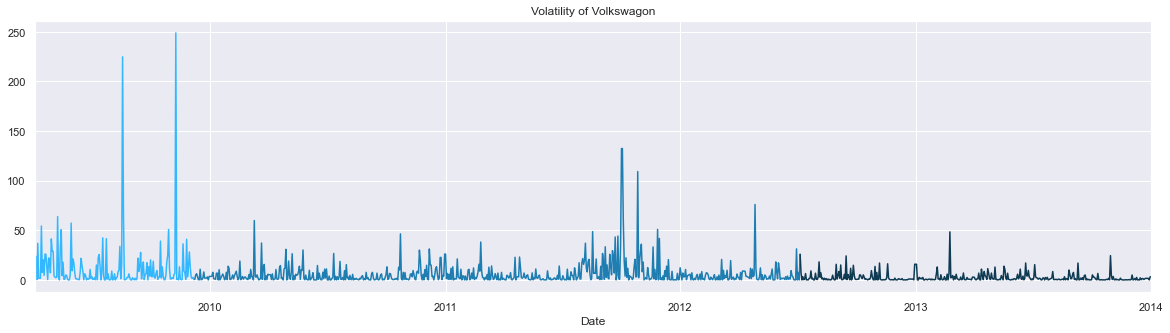

In [92]:
# Volatility
df['sq_vol'][start_date:ann_1].plot(figsize = (20,5), color = "#33B8FF")
df['sq_vol'][ann_1:ann_2].plot(color = "#1E7EB2")
df['sq_vol'][ann_2:end_date].plot(color = "#0E3A52")
plt.title("Volatility of Volkswagon")
plt.show()

In [93]:
model_garch_pre = arch_model(df.ret_vol[start_date:ann_1], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_pre = model_garch_pre.fit(update_freq = 5)

model_garch_btn = arch_model(df.ret_vol[ann_1:ann_2], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_btn = model_garch_btn.fit(update_freq = 5)

model_garch_post = arch_model(df.ret_vol[ann_2:end_date], mean = "Constant",  vol = "GARCH", p = 1, q = 1)
results_garch_post = model_garch_post.fit(update_freq = 5)

Iteration:      5,   Func. Count:     31,   Neg. LLF: 475.77856008358845
Iteration:     10,   Func. Count:     56,   Neg. LLF: 475.0041695543186
Iteration:     15,   Func. Count:     80,   Neg. LLF: 474.99143448069555
Optimization terminated successfully    (Exit mode 0)
            Current function value: 474.9914344283906
            Iterations: 15
            Function evaluations: 80
            Gradient evaluations: 15
Iteration:      5,   Func. Count:     38,   Neg. LLF: 1526.7535667082716
Iteration:     10,   Func. Count:     62,   Neg. LLF: 1526.7316357715022
Optimization terminated successfully    (Exit mode 0)
            Current function value: 1526.731635770258
            Iterations: 10
            Function evaluations: 62
            Gradient evaluations: 10
Iteration:      5,   Func. Count:     34,   Neg. LLF: 724.5622300180914
Optimization terminated successfully    (Exit mode 0)
            Current function value: 724.5578792535903
            Iterations: 7
            

In [94]:
results_garch_pre.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -474.991
Distribution:                  Normal   AIC:                           957.983
Method:            Maximum Likelihood   BIC:                           970.710
                                        No. Observations:                  178
Date:                Wed, Dec 30 2020   Df Residuals:                      174
Time:                        09:12:33   Df Model:                            4
                               Mean Model                               
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0.1571      0.266      0.590      0.556 [ -0.365,  0.679]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega         10.6194      4.227      2.512  1.200e-02    [  2.334, 18.905]
alpha[1]       0.1540  9.197e-02      1.675  9.400e-02 [-2.624e-02,  0.334]
beta[1]    4.7917e-13      0.349  1.372e-12      1.000    [ -0.684,  0.684]
===========================================================================

Covariance estimator: robust
"""

In [95]:
results_garch_btn.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                      GARCH   Log-Likelihood:               -1526.73
Distribution:                  Normal   AIC:                           3061.46
Method:            Maximum Likelihood   BIC:                           3079.50
                                        No. Observations:                  672
Date:                Wed, Dec 30 2020   Df Residuals:                      668
Time:                        09:12:33   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1892  8.634e-02      2.191  2.843e-02 [1.998e-02,  0.358]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          0.1679  7.914e-02      2.122  3.388e-02 [1.279e-02,  0.323]
alpha[1]       0.0688  1.682e-02      4.091  4.302e-05 [3.585e-02,  0.102]
beta[1]        0.9040  2.108e-02     42.883      0.000   [  0.863,  0.945]
==========================================================================

Covariance estimator: robust
"""

In [96]:
results_garch_post.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                ret_vol   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -724.558
Distribution:                  Normal   AIC:                           1457.12
Method:            Maximum Likelihood   BIC:                           1472.98
                                        No. Observations:                  390
Date:                Wed, Dec 30 2020   Df Residuals:                      386
Time:                        09:12:33   Df Model:                            4
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.2298  9.845e-02      2.334  1.958e-02 [3.685e-02,  0.423]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.7719      0.677      1.141      0.254    [ -0.554,  2.098]
alpha[1]       0.1853      0.145      1.273      0.203 [-9.991e-02,  0.470]
beta[1]        0.5136      0.331      1.550      0.121    [ -0.136,  1.163]
===========================================================================

Covariance estimator: robust
"""

In [13]:
sgt.plot_acf(ret_vol, unbiased= True, zero = False, lags=40)
plt.title("ACF for Returns", size = 20)
plt.show()

NameError: name 'ret_vol' is not defined

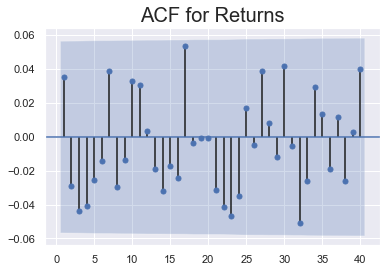

In [25]:
sgt.plot_acf(return_vol, unbiased= True, zero = False, lags=40)
plt.title("ACF for Returns", size = 20)
plt.show()

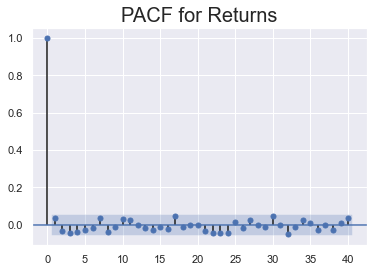

In [31]:
plot_pacf(return_vol, lags=40)
plt.title("PACF for Returns", size = 20)
plt.show()